In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
from src.folder_handler import *
from src.cort_processor import *
from src.tdt_support import *
from src.plotter import *
from src.decoders import *
import pickle
import scipy as spicy
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
from src.wiener_filter import *
from matplotlib.pyplot import cm
from scipy import signal

In [2]:
def predicted_lines(actual, H):
    holding_array = []
    for ii in range(0,7):
        temp1 = test_wiener_filter(actual, H[:,ii])
        holding_array.append(temp1)
    holding_array = np.array(holding_array).T
    return holding_array

In [9]:
def to_phase_angle(rates, angles):
    cos_list = []
    sin_list = []
    phase_list = []
    # holding_array = []
    for i in range(len(angles)):
        cos_array = []
        sin_array = []
        raw_phase_angle = []
        for ii in range(angles[i].shape[1]):
            # holding_array = np.zeros(angles[i].shape)
            peak_list = []
            peak_dict = {
                    0 : {
                        'signal': -(angles[i][:,ii]),
                        'prominence': 5,
                        'distance': 5,
                        'width' : 2,
                        'height' : -1.25*np.mean(angles[i][:,ii])
                    },
                    1 : {
                        'signal': angles[i][:,ii],
                        'prominence': 10,
                        'distance': None,
                        'width' : None,
                        'height' : np.mean(angles[i][:,ii])
                    },
                    2 : {
                        'signal': angles[i][:,ii],
                        'prominence': 5,
                        'distance': None,
                        'width' : 2,
                        'height' : np.mean(angles[i][:,ii])
                    },
                    3 : {
                        'signal': angles[i][:,ii],
                        'prominence': 10,
                        'distance': None,
                        'width' : None,
                        'height' : np.mean(angles[i][:,ii])
                    },
                    4 : {
                        'signal': angles[i][:,ii],
                        'prominence': 6.5,
                        'distance': 5,
                        'width' : None,
                        'height' : 1.1*np.mean(angles[i][:,ii])
                    },
                    5 : {
                        'signal': -(angles[i][:,ii]),
                        'prominence': 5,
                        'distance': None,
                        'width' : None,
                        'height' : -1.1*np.mean(angles[i][:,ii])
                    },
                    6 : {
                        'signal': angles[i][:,ii],
                        'prominence': 9,
                        'distance': 5,
                        'width' : None,
                        'height' : None
                    }
                }
            peak_list, _ = spicy.signal.find_peaks(peak_dict[ii]['signal'], prominence=peak_dict[ii]['prominence'], distance =peak_dict[ii]['distance'], width =peak_dict[ii]['width'], height =peak_dict[ii]['height'])
            angle_storage = angles[i][:,ii].copy()
            for iii in range(0,peak_list.shape[0]-1):
                for iv in range(0, peak_list[iii+1]-peak_list[iii]):
                    angle_storage[peak_list[iii]+iv] = iv*360/(peak_list[iii+1]-peak_list[iii])
            angle_storage[peak_list[-1]] = 0
            angle_sin = (np.sin(angle_storage*np.pi/180))
            sin_array.append(angle_sin)
            angle_cos = (np.cos(angle_storage*np.pi/180))
            cos_array.append(angle_cos)
            raw_phase_angle.append(angle_storage)
        sin_array = np.array(sin_array).T
        sin_list.append(sin_array)
        cos_array = np.array(cos_array).T
        cos_list.append(cos_array)
        raw_phase_angle = np.array(raw_phase_angle).T
        phase_list.append(raw_phase_angle)
    h, _, _, _ = session512.decode_angles(X=rates, Y=angles)
    h_sin, _, _, _ = session512.decode_angles(X=rates, Y=sin_list)
    h_cos, _, _, _ = session512.decode_angles(X=rates, Y=cos_list)
    full_rates, full_angles = session512.stitch_and_format(rates, angles)
    _, full_sin = session512.stitch_and_format(rates, sin_list)
    _, full_cos = session512.stitch_and_format(rates, cos_list)
    _, full_phase = session512.stitch_and_format(rates, phase_list)
    predicted_angle = predicted_lines(full_rates, h)
    predicted_sin = predicted_lines(full_rates, h_sin)
    predicted_cos = predicted_lines(full_rates, h_cos)
    tsf = np.linspace(0, (full_angles.shape[0]*50)/1000,full_angles.shape[0])
    arctans = []
    for i in range(predicted_sin.shape[1]):
        arctan_angles = (np.arctan2(predicted_sin[:,i],predicted_cos[:,i]) * 180 / np.pi) +180
        arctans.append(arctan_angles)
    arctans = np.array(arctans).T
    return tsf, arctans, full_phase, h_sin, h_cos

In [25]:
def alignment_check(tsf, arctans, full_phase):
    dx = np.mean(np.diff(tsf))
    temp_shift = []
    target = [arctans[:,0], arctans[:,1], arctans[:,2], arctans[:,3], arctans[:,4], arctans[:,5], arctans[:,6]]
    for i in range(len(target)):
        shift = (np.argmax(signal.correlate(full_phase[:,i], target[i])) - len(target[i])) * dx
        temp_shift.append(shift)
    return temp_shift

In [10]:
with open('/mnt/c/oobootoo/rat-fes/data/pickles/rat-annie_5-12_session.pkl', 'rb') as inp:
    session512 = pickle.load(inp)
rates512 = session512.data['rates']
angles512 = session512.data['angles']
coords512 = session512.data['coords']

In [11]:
with open('/mnt/c/oobootoo/rat-fes/data/pickles/data_greg818_session.pkl', 'rb') as inp:
    session818 = pickle.load(inp)
rates818 = session818.data['rates']
angles818 = session818.data['angles']
coords818 = session818.data['coords']

In [15]:
tsf512, arctans512, full_phase512, _ , _ = to_phase_angle(rates512, angles512)

In [16]:
tsf818, arctans818, full_phase818, _ , _ = to_phase_angle(rates818, angles818)

In [27]:
print(alignment_check(tsf512, arctans512, full_phase512))
print(alignment_check(tsf818, arctans818, full_phase818))

[-0.35002463227531844, -0.35002463227531844, -0.35002463227531844, -0.35002463227531844, -0.35002463227531844, -0.35002463227531844, -0.35002463227531844]
[-0.4500326394429536, -0.4500326394429536, -0.4500326394429536, -0.4500326394429536, -0.40002901283818093, -0.40002901283818093, -0.4500326394429536]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
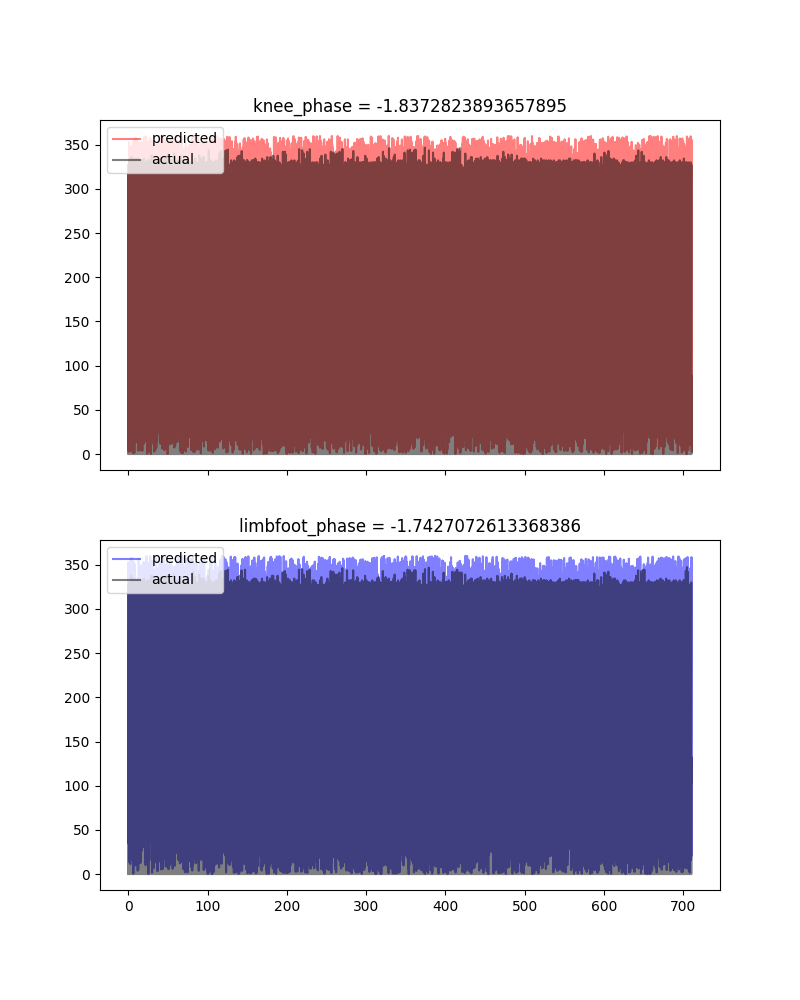

In [20]:
fig512, ax = plt.subplots(2, 1, figsize=(8,10), sharex = True)
ax[0].set_title('knee_phase = ' + str(vaf(full_phase512[:,1],arctans512[:,1])))
ax[0].plot(tsf512, arctans512[:,1], c='r', alpha=0.5, label = "predicted")
ax[0].plot(tsf512, full_phase512[:,1], c='k', alpha=0.5, label = "actual")
ax[0].legend(loc="upper left")
ax[1].set_title('limbfoot_phase = ' + str(vaf(full_phase512[:,3],arctans512[:,3])))
ax[1].plot(tsf512, arctans512[:,3], c='blue', alpha=0.5, label = "predicted")
ax[1].plot(tsf512, full_phase512[:,3], c='k', alpha=0.5, label = "actual")
ax[1].legend(loc="upper left")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
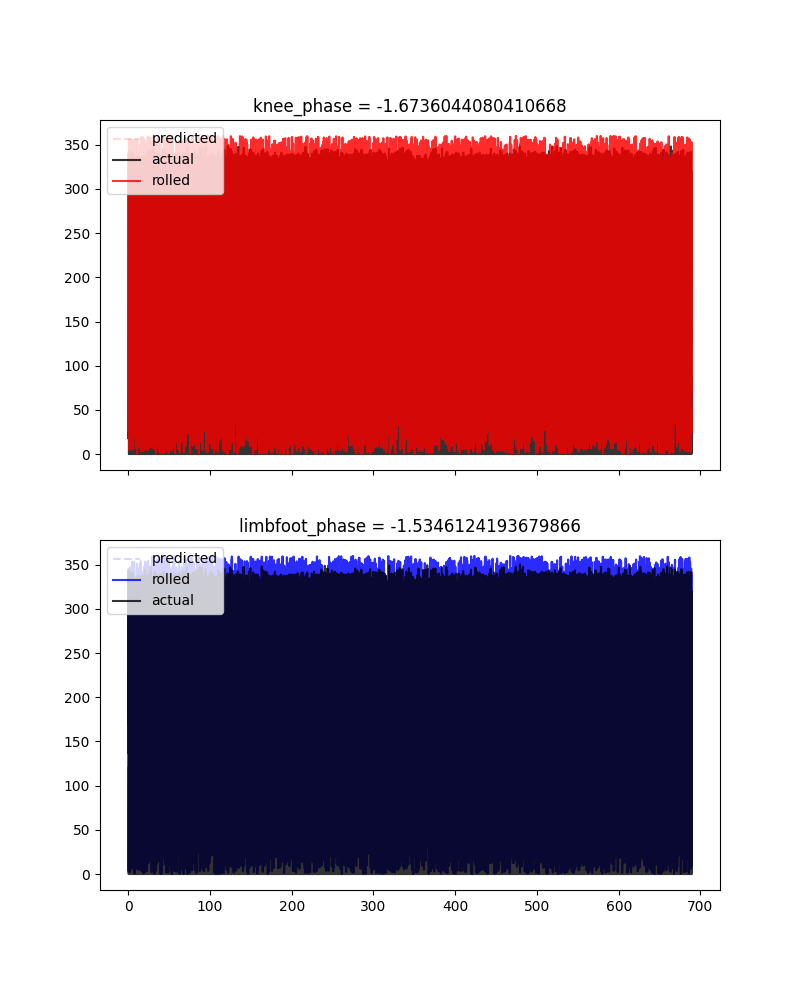

In [34]:
fig818, ax = plt.subplots(2, 1, figsize=(8,10), sharex = True)
ax[0].set_title('knee_phase = ' + str(vaf(full_phase818[:,1],arctans818[:,1])))
ax[0].plot(tsf818, arctans818[:,1], c='r', alpha=0.15, label = "predicted",linestyle = '--')
ax[0].plot(tsf818, full_phase818[:,1], c='k', alpha=0.8, label = "actual")
ax[0].plot(tsf818, np.roll(arctans818[:,1],-9), c='r', alpha=0.8, label = "rolled")

ax[0].legend(loc="upper left")
ax[1].set_title('limbfoot_phase = ' + str(vaf(full_phase818[:,3],arctans818[:,3])))
ax[1].plot(tsf818, arctans818[:,3], c='blue', alpha=0.15, label = "predicted", linestyle = '--')
ax[1].plot(tsf818, np.roll(arctans818[:,3],-9), c='blue', alpha=0.8, label = "rolled")
ax[1].plot(tsf818, full_phase818[:,3], c='k', alpha=0.8, label = "actual")
ax[1].legend(loc="upper left")